# Hyperparameter tuning

## Imports

In [1]:
from inspect import signature

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sweetviz as sv
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score, matthews_corrcoef,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

d:\Anaconda\envs\PGM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Load and Split

In [2]:
x_df = pd.read_csv('..\\data\\features.csv')
y_df = pd.read_csv('..\\data\\labels.csv')

display(x_df.head())
display(y_df.head())

,username,link_karma,comment_karma,account_age,is_verified,avg_cosine_similarity,all_users_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio,avg_thread_depth,parent_child_similarity,avg_ttr,avg_flesch_kincaid_grade,ngram_overlap
0,yakfsh1,19830.0,88232.0,1440.0,True,1.0,1.0,382.0,382.0,382.0,1.0,0.500000,0.0,0.931034,12.1,0.0
1,Tsquare43,699100.0,720902.0,3636.0,True,1.0,1.0,62.0,62.0,62.0,1.0,0.666667,0.0,0.927318,6.9,0.0
2,SeaSpeakToMe,236.0,11628.0,1029.0,True,NaN,1.0,75.0,81.0,67.0,1.0,1.000000,0.0,1.000000,1.3,0.0
3,hurtingxliving,848.0,1275.0,2001.0,True,NaN,1.0,39.0,39.0,39.0,1.0,0.000000,0.0,0.888889,12.6,0.0
4,Minute-Photo6916,1.0,4.0,12.0,True,NaN,1.0,15.0,15.0,15.0,1.0,1.000000,0.0,1.000000,-2.3,0.0


,username,is_bot
0,yakfsh1,False
1,Tsquare43,False
2,SeaSpeakToMe,False
3,hurtingxliving,False
4,Minute-Photo6916,False


In [3]:
def create_balanced_dataset(y_df, x_df, bot_ratio=0.4):
    merged_df = pd.merge(y_df, x_df, on='username')
    bot_users = merged_df[merged_df['is_bot'] == True]

    num_bots = len(bot_users)
    num_non_bots = int((num_bots / bot_ratio) - num_bots)
    non_bot_users = merged_df[merged_df['is_bot'] == False].sample(n=num_non_bots, random_state=42)
    balanced_df = pd.concat([bot_users, non_bot_users])

    new_y_df = balanced_df[['username', 'is_bot']]
    new_x_df = balanced_df.drop(columns=['is_bot'])
    
    return new_x_df, new_y_df

In [4]:
X_df_balanced, y_df_balanced = create_balanced_dataset(y_df, x_df)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_df_balanced, y_df_balanced, test_size=0.2, random_state=42, stratify=y_df_balanced['is_bot'])

## Data preprocessing

In [6]:
def drop_columns(X, columns):
    return X.drop(columns, axis=1)


def replace_none(X, column_value_pairs):
    for column, value in column_value_pairs.items():
        X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)
    return X

def convert_bool(X, columns):
    for column in columns:
        X.loc[:, column] = X[column].apply(lambda x: 1 if x else 0)
    return X


def drop_rows_with_none(X, columns):
    return X.dropna(subset=columns)


In [7]:
class CustomStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_standardize):
        self.columns_to_standardize = columns_to_standardize
        self.standard_scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='constant', fill_value=1)

    def fit(self, X, y=None):
        X = X.copy()
        without_none = X.dropna(subset=self.columns_to_standardize)
        self.standard_scaler.fit(without_none[self.columns_to_standardize])
        self.imputer.fit(X[self.columns_to_standardize])
        return self

    def transform(self, X, y=None):
        without_none = X.dropna(subset=self.columns_to_standardize)
        with_none = X[~X.index.isin(without_none.index)]
        X_standardized = self.standard_scaler.transform(without_none[self.columns_to_standardize])
        X_combined = np.hstack([X_standardized, without_none.drop(columns=self.columns_to_standardize, axis=1)])
        X_combined_df = pd.DataFrame(X_combined, index=without_none.index, columns=list(self.columns_to_standardize) + list(without_none.drop(columns=self.columns_to_standardize, axis=1).columns))
        X_final = pd.concat([X_combined_df, with_none], axis=0).sort_index()
        X_final[self.columns_to_standardize] = self.imputer.transform(X_final[self.columns_to_standardize])
        return X_final

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_columns, contamination=0.01):
        self.outlier_columns = outlier_columns
        self.contamination = contamination
        self.clf = IsolationForest(n_estimators=100, contamination=self.contamination, random_state=42)

    def fit(self, X, y=None):
        X_copy = X[self.outlier_columns].copy()
        self.clf.fit(X_copy)
        return self

    def transform(self, X, y=None):
        X_copy = X[self.outlier_columns].copy()
        outliers = self.clf.predict(X_copy)
        mask = outliers == 1
        if y is None:
            return X[mask]
        else:
            return X[mask], y.loc[X[mask].index]
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X, y)


class CustomColumnTransformer(ColumnTransformer):
    def fit(self, X, y=None):
        if isinstance(X, tuple):
            X, y = X
        result = super().fit(X, y)
        return result, y

    def transform(self, X, y=None):
        y = None
        if isinstance(X, tuple):
            X, y = X
        result = super().transform(X)
        return result, y

    def fit_transform(self, X, y=None):
        if isinstance(X, tuple):
            X, y = X
        result = super().fit_transform(X, y)
        return result, y

In [8]:
columns_to_drop = ["username", "parent_child_similarity"]
to_standardization = [
    "avg_comment_length",
    "max_comment_length",
    "min_comment_length",
    "avg_flesch_kincaid_grade",
    "link_karma",
    "comment_karma",
    "account_age",
    "is_verified",
]
columns_to_standardize_before_replace = [
    "comment_post_ratio",
]
columns_to_replace_none = {
    'avg_cosine_similarity': 0,
    'all_users_similarity': 0,
    'avg_thread_depth': 0,
    'avg_ttr': 0,
    'ngram_overlap': 0,
    "avg_comment_length": 0,
    "max_comment_length": 0,
    "min_comment_length": 0,
    "avg_flesch_kincaid_grade": 0,
    "link_karma": 0,
    "comment_karma": 0,
    "account_age": 0,
    "is_verified": 0,
}
columns_to_drop_none = [
    'link_karma',
    'comment_karma',
    'account_age',
    'is_verified',
]
columns_to_convert_bool = [
    'is_verified',
]
to_remove_outliers = [
    'link_karma',
    'comment_karma',
    "avg_comment_length",
    "max_comment_length",
    "min_comment_length",
]

In [9]:
none_transformer = Pipeline(
    steps=[
        ('drop_columns', FunctionTransformer(drop_columns, kw_args={'columns': columns_to_drop})),
        ('drop_rows_with_none', FunctionTransformer(drop_rows_with_none, kw_args={'columns': columns_to_drop_none})),
        ('convert_bool', FunctionTransformer(convert_bool, kw_args={'columns': columns_to_convert_bool})),
        ('replace_none_without_std', FunctionTransformer(replace_none, kw_args={'column_value_pairs': columns_to_replace_none})),
    ]
)

column_preprocessor = CustomColumnTransformer(
    transformers=[
        ('standardization', StandardScaler(), to_standardization),
        ('std_before_replace', CustomStandardizer(columns_to_standardize_before_replace), columns_to_standardize_before_replace),
    ], remainder='passthrough'
)

In [10]:
class CustomPipeline(Pipeline):
    def transform(self, X, y=None, **transform_params):
        Xt = X
        for _, name, transform in self._iter(with_final=False):
            if hasattr(transform, "transform"):
                # Check if transform accepts y as a parameter
                sig = signature(transform.transform)
                if "y" in sig.parameters:
                    Xt = transform.transform(Xt, y=y, **transform_params)
                else:
                    Xt = transform.transform(Xt, **transform_params)
        return Xt

In [11]:
preprocessing_pipeline = CustomPipeline(
    steps=[
        ('none_transformer', none_transformer),
        ('outlier_remover', OutlierRemover(to_remove_outliers)),
        ('column_preprocessor', column_preprocessor),
    ]
)

In [12]:
X_train_preprocessed, y_train_preprocessed = preprocessing_pipeline.fit_transform(X_train, pd.DataFrame(y_train['is_bot']))
X_test_preprocessed, y_test_preprocessed = preprocessing_pipeline.transform(X_test, pd.DataFrame(y_test['is_bot']))

C:\Users\dawir\AppData\Local\Temp\ipykernel_20256\3790178958.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)
C:\Users\dawir\AppData\Local\Temp\ipykernel_20256\3790178958.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)


In [13]:
X_train_preprocessed.shape, y_train_preprocessed.shape, X_test_preprocessed.shape, y_test_preprocessed.shape

((4284, 14), (4284, 1), (1064, 14), (1064, 1))

## Train

In [30]:
def print_metrics(y_true, y_pred):
    print(f"Confusion matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"Matthews correlation coefficient: {matthews_corrcoef(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


In [20]:
y_train_preprocessed_np = y_train_preprocessed.values.ravel()
X_test_preprocessed_np = X_test_preprocessed.values

In [21]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_preprocessed, y_train_preprocessed_np)

RandomForestClassifier(random_state=42)

In [23]:
predictions = rfc.predict(X_test_preprocessed_np)

Confusion matrix:
[[329 301]
 [204 230]]
Matthews correlation coefficient: 0.05128332970623233
Recall: 0.5299539170506913
Precision: 0.4331450094161959
F1 score: 0.47668393782383417
Accuracy: 0.525375939849624


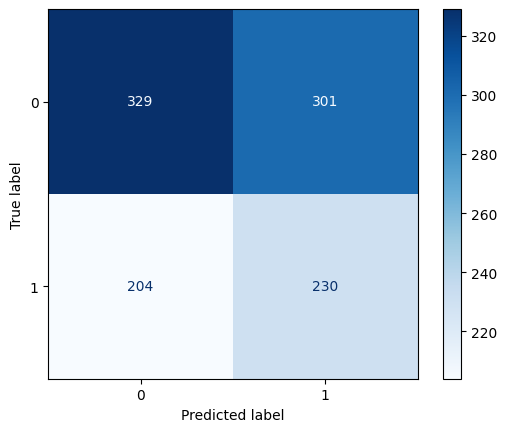

In [31]:
print_metrics(y_test_preprocessed, predictions)